# **Importing Libraries**

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from importlib import reload
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import glob
from shutil import copyfile
from keras.models import load_model
from keras import optimizers

## **Load the Resnet50 model from keras**

In [2]:
img_shape = (224, 224, 3)
resnet_model = ResNet50(include_top=False, input_shape=img_shape) #Exclude the top Layer by adding include_top=False

## **Load the images and Preprocess the images**

In [3]:
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
] #37 vectors of Galaxy Zoo divided into 11 classes based on the 11 different questions and their responses


def append_ext(fn):
    '''
    This function is used to take the GalaxyID from the CSV and append .jpg to it in order to denote the image names. 
    '''
    return fn + ".jpg"


traindf = pd.read_csv('../Data/GalaxyZoo1/train/training_solutions_rev1.csv') #Read the Data Frame using pandas

traindf["id"] = traindf['GalaxyID'].astype(str).apply(append_ext) #Create a new column in the Data Frame called 'id' which has the image names.

datagenerator = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1/255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.02)

train_generator = datagenerator.flow_from_dataframe(
    dataframe=traindf,
    directory="../Data/GalaxyZoo1/train/images_training_rev1/",
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=16,
    seed=123,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224))

validation_generator = datagenerator.flow_from_dataframe(
    dataframe=traindf,
    directory="../Data/GalaxyZoo1/train/images_training_rev1/",
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=16,
    seed=123,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224))

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

Found 60347 validated image filenames.
Found 1231 validated image filenames.


In [4]:
# Flatten output of last layer before adding output layer (Dense layer)
x = Flatten()(resnet_model.output)

# Add output layer (number of outputs = 37)
x = Dense(len(classes), activation='sigmoid')(x)

# Load the modified model
model = Model(inputs=resnet_model.input, outputs=x)

In [5]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [6]:
for layer in model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=5e-4)

model.compile(optimizer, loss='mse', metrics=["accuracy"])

In [7]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=4, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='../../weights.hdf5', verbose=2, save_best_only=True)

In [8]:
hist = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,
    callbacks=[history, checkpointer, early_stopping])

Epoch 1/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.3113
Epoch 1: val_loss improved from inf to 0.02185, saving model to ../..\weights.hdf5
3771/3771 [==============================] - 2504s 662ms/step - loss: 0.0454 - accuracy: 0.3113 - val_loss: 0.0218 - val_accuracy: 0.6086
Epoch 2/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.5759
Epoch 2: val_loss improved from 0.02185 to 0.01868, saving model to ../..\weights.hdf5
3771/3771 [==============================] - 1002s 266ms/step - loss: 0.0217 - accuracy: 0.5759 - val_loss: 0.0187 - val_accuracy: 0.6554
Epoch 3/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.6179
Epoch 3: val_loss improved from 0.01868 to 0.01702, saving model to ../..\weights.hdf5
3771/3771 [==============================] - 1003s 266ms/step - loss: 0.0204 - accuracy: 0.6179 - val_loss: 0.0170 - val_accuracy: 0.6719
Epoch 4/30
3771/3771 [=============

Epoch 28/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.7958
Epoch 28: val_loss improved from 0.00906 to 0.00893, saving model to ../..\weights.hdf5
3771/3771 [==============================] - 1008s 267ms/step - loss: 0.0090 - accuracy: 0.7958 - val_loss: 0.0089 - val_accuracy: 0.8158
Epoch 29/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.7928
Epoch 29: val_loss did not improve from 0.00893
3771/3771 [==============================] - 1005s 267ms/step - loss: 0.0089 - accuracy: 0.7928 - val_loss: 0.0092 - val_accuracy: 0.8117
Epoch 30/30
3771/3771 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.7955
Epoch 30: val_loss improved from 0.00893 to 0.00869, saving model to ../..\weights.hdf5
3771/3771 [==============================] - 1008s 267ms/step - loss: 0.0088 - accuracy: 0.7955 - val_loss: 0.0087 - val_accuracy: 0.8100


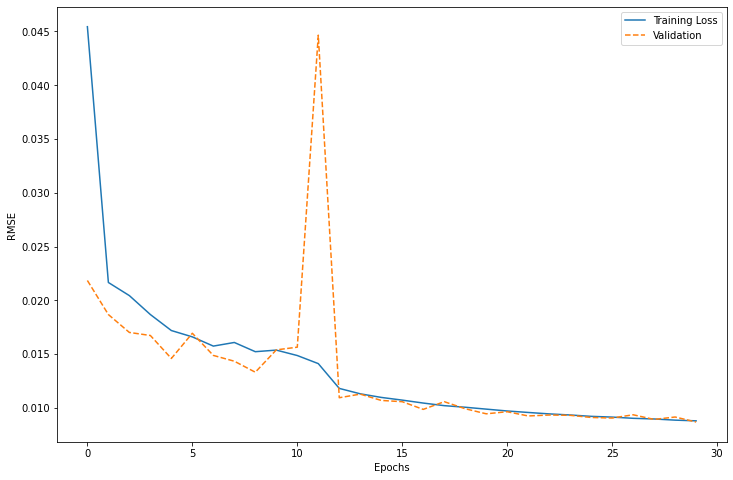

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
plt.plot(
    hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [10]:
from keras.models import load_model

model = load_model('../../weights.hdf5')

In [22]:
test_datagenerator = ImageDataGenerator(rescale=1/255)

test_generator = test_datagenerator.flow_from_directory(
    directory="../Data/GalaxyZoo1/test/",
    classes=['images_test_rev1'],
    class_mode=None,
    color_mode="rgb",
    batch_size=1,
    target_size=(224, 224),
    seed=123,
    shuffle=False)

Found 79975 images belonging to 1 classes.


In [23]:
predictions = model.predict(
    test_generator,
    steps=test_generator.n/test_generator.batch_size,
    verbose=1)

print(predictions.shape)

79975/79975 [==============================] - 1146s 14ms/step
(79975, 37)
